NOT: Bu dosyada iki farklı makine öğrenimi uygulanmıştır. İlk uygulamada Pseudomonas Aeruginosa bakterisine ait protein dizilimleri 7 farklı bakteriye ait protein dizilimleriyle (Oluşturulan dosyaya klasör içindeki other_bacteria.ipynb dosyasından ulaşabilirsiniz.) eğitilerek dizilim tahmini yapılmıştır. İkinci uygulamada ise Pseudomonas Aeruginosa bakterisine ait bir proteinin diğer özelliklerine dayanarak molekül ağırlığı tahmin edilmeye çalışılmıştır.

pseudomononas_aeruginosa Veri Seti Linki :
https://www.kaggle.com/datasets/jiscecseaiml/pseudomonas-aeruginosa

Veri Setinin Hikayesi :
Pseudomonas aeruginosa, çeşitli ortamlardaki olağanüstü çok yönlülüğü ve dayanıklılığıyla tanınan bir Gram-negatif bakteridir. Özellikle bağışıklık sistemi zayıflamış bireylerde enfeksiyonların başlıca nedeni olduğu sağlık ortamlarında yaygın bir patojendir.

Veri seti, her biri aşağıdaki niteliklerle karakterize edilen 1.000 protein girişinden oluşur:

ID: Her protein girişi için benzersiz bir tanımlayıcı.

Name: Proteinin adı.

Sequence: Proteinin yapısını ve işlevini belirlemek için temel olan amino asit dizisi.

Moleküler Ağırlık: Proteinin boyutunu ve diğer moleküllerle nasıl etkileşime girdiğini anlamak için çok önemli olan, Dalton (Da) cinsinden proteinin hesaplanan moleküler ağırlığı.

İzoelektrik Nokta (pI): Proteinin net elektrik yükü taşımadığı ve çözünürlüğünü ve diğer moleküllerle etkileşimini etkileyen pH.

Protein Uzunluğu: Proteinin boyutunu ve potansiyel karmaşıklığını gösteren protein dizisindeki amino asit sayısı.

Amino Asit Bileşimi: Protein dizisindeki her amino asidin sıklığı veya yüzdesi, proteinin yapısal özellikleri ve işlevsel rolleri hakkında fikir verir.

Hidrofobisite: Proteinin katlanmasında, stabilitesinde ve diğer biyomoleküllerle etkileşimlerinde kritik rol oynayan hidrofobik (su itici) özelliklerinin bir ölçüsüdür. Kyte-Doolittle ölçeği ile hesaplanır.

MAKİNE ÖĞRENİMİ - 1

1-GEREKLİ KÜTÜPHANELERİN İÇE AKTARILMASI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

In [2]:
# Veri setlerini yüklüyoruz. Burada other_bacteria_sequences.csv dosyası 7 farklı bakteri ve bu bakterilere ait ID ve Protein dizilimlerinin UniProt üzerinden elde edilip birleştirilmesiyle oluşturulmuştur.
pseudo_data = pd.read_csv("pseudomonas_aeruginosa.csv")
other_data = pd.read_csv("other_bacteria_sequences.csv")

2-VERİ ÖN İŞLEME

In [3]:
# Veri setlerimize uygun etiketleri ekliyoruz.
pseudo_data["Label"] = 1
other_data["Label"] = 0

In [4]:
# İki veri setini uygun şekilde birleştiriyoruz.
combined_data = pd.concat([pseudo_data, other_data], ignore_index=True)

In [5]:
# Eksik verilerin kontrolünü yapıyoruz. Bu noktada ilk veri setinde ikinci veri setinde bulunmayan sütunlar olduğu için çıktıda o sütunlar için eksik değerler göreceğiz.
print("Eksik Veri Analizi:\n", combined_data.isnull().sum())

Eksik Veri Analizi:
 ID                          0
Name                      734
Sequence                    0
Molecular_Weight          734
Isoelectric_Point         734
Protein_Length            734
Amino_Acid_Composition    734
Hydrophobicity            734
Label                       0
dtype: int64


3-VERİ KEŞFİ

In [6]:
# Veri kümesinin ilk 5 satırının ve bilgilerinin görüntülenmesi
print("Veri kümesinin ilk 5 satırı:\n", combined_data.head())
print("Veri sütunları ve türleri:\n", combined_data.info())

Veri kümesinin ilk 5 satırı:
                ID                                               Name  \
0  WP_369686368.1  ATP-binding cassette domain-containing protein...   
1  WP_369686367.1  aldehyde dehydrogenase family protein, partial...   
2  WP_369686366.1  hypothetical protein, partial [Pseudomonas aer...   
3  WP_369686365.1  hypothetical protein, partial [Pseudomonas aer...   
4  WP_369686364.1  homocysteine S-methyltransferase family protei...   

                                            Sequence  Molecular_Weight  \
0  MLELNFTQTLGSHTLTLNETLPASGITAIFGVSGAGKTSLINAISG...         5756.5430   
1  MQSRDNGKPLAEARGLVMSAAGTARYFAAACELLDGELPTPRQPDR...         6617.5065   
2  GGEYLEIIEAARDIRVELDAHNYISNILTKLGIDRPSGLTRVMDLA...         9303.2892   
3  NAVVNQKRVPLAPNGDMLAPGQEKTLSFSGDITRIADIAYTTINDF...         6304.0708   
4                 MAGYLPQWLDAGAKLIGGCCRTTPQDIAALTVQR         3619.1997   

   Isoelectric_Point  Protein_Length  \
0           8.517644            56.0   
1           

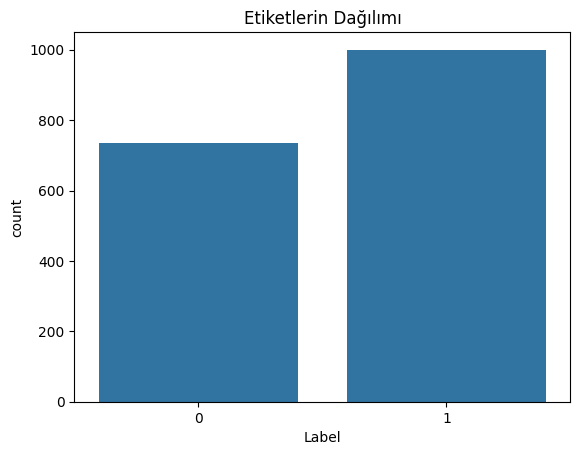

In [7]:
# Etiketlerin dağılımını görselleştiriyoruz.
sns.countplot(data=combined_data, x="Label")
plt.title("Etiketlerin Dağılımı")
plt.show()

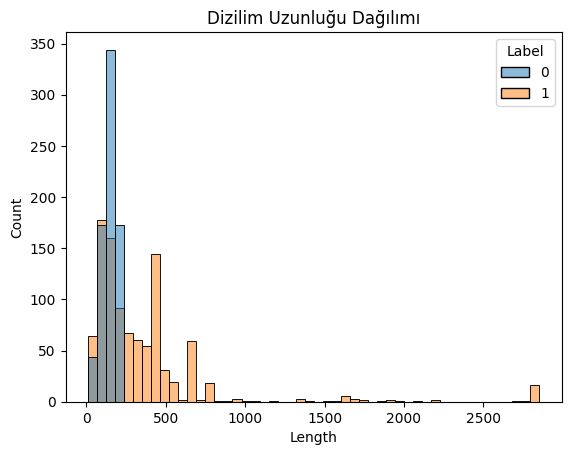

In [8]:
# Dizilim uzunluğu dağılımını tablo şeklinde görüntülüyoruz.
combined_data["Length"] = combined_data["Sequence"].str.len()
sns.histplot(data=combined_data, x="Length", hue="Label", bins=50)
plt.title("Dizilim Uzunluğu Dağılımı")
plt.show()

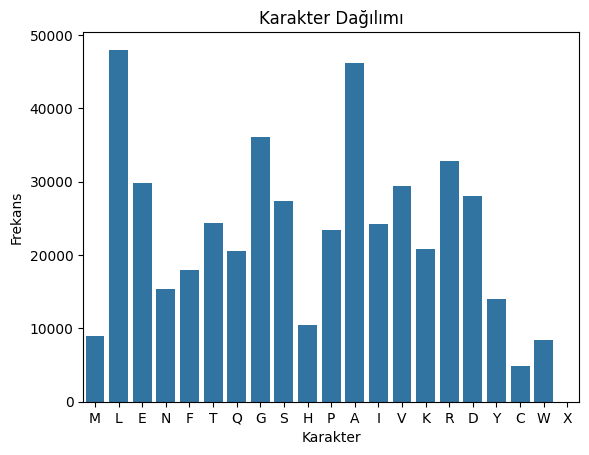

In [9]:
# Dizilimlerdeki karakter sıklığını inceliyoruz.
from collections import Counter

def plot_character_distribution(sequence_column):
    char_counts = Counter(''.join(sequence_column.dropna()))
    chars, counts = zip(*char_counts.items())
    sns.barplot(x=list(chars), y=list(counts))
    plt.title("Karakter Dağılımı")
    plt.xlabel("Karakter")
    plt.ylabel("Frekans")
    plt.show()

plot_character_distribution(combined_data["Sequence"])


In [10]:
# Dizilimleri sayısallaştırma işlemi gerçekleştiriyoruz. Makine öğrenimi için en uygun olan verilerin sayısal türde olmasıdır.
vectorizer = CountVectorizer(analyzer="char", ngram_range=(1, 1))
X = vectorizer.fit_transform(combined_data["Sequence"])
y = combined_data["Label"]

In [11]:
# Verileri test ve train olarak ayırıyoruz.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
#from sklearn.linear_model import LogisticRegression
#model = LogisticRegression()
#LogisticRegresiion çalıştırıldığında ccuracy değeri : 0.8789

In [13]:
#from sklearn.svm import SVC
#model = SVC(probability=True)
#Support Vector Machine çalıştırıldığında accuracy değeri : 0.8993

In [14]:
# Sonuçlar doğrultusunda model eğitimi için RandomForestClassifier kullanmayı tercih ettim.
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Tahmin
y_pred = model.predict(X_test)
# Performans değerlendirmesi yapıyoruz.
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9250720461095101
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       143
           1       0.93      0.94      0.94       204

    accuracy                           0.93       347
   macro avg       0.92      0.92      0.92       347
weighted avg       0.92      0.93      0.92       347



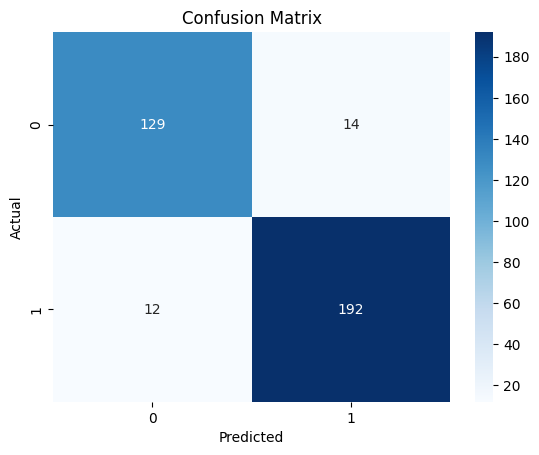

In [16]:
# Confusion Matrix Tablosu
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [17]:
# ROC-AUC Değerlendirmesi
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.9817804744275332


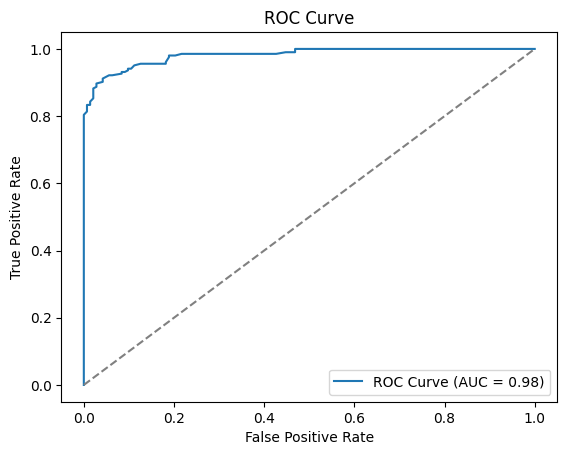

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [19]:
# Yeni dizilim tahmini yapıyoruz. Burada kullandığım protein dizilim pseudomonas aeruginosa' ya aittir.
new_sequence = ["MLELNFTQTLGSHTLTLNETLPASGITAIFGVSGAGKTSLINAISGLTRPQSGRIV	"]
new_sequence_transformed = vectorizer.transform(new_sequence)
prediction = model.predict(new_sequence_transformed)
if prediction[0] == 1:
    print("Tahmin (Label):", "Pseudomonas aeruginosa")
else:
    print("Tahmin (Label):", "Diğer")

Tahmin (Label): Pseudomonas aeruginosa


In [20]:
# Yeni dizilim tahmini yapıyoruz. Burada kullandığım protein dizilim farklı bir bakteriye aittir.
new_sequence = ["MFNQVMLVGRLTKDPDLRYTSAGAAVAHVTLAVNRSFKNASGEIEADYVNCTLWRKTAENTALYCQKGSLVGVSGRIQTRSYENEEGVNVYVTEVLADTVRFMDPKPREKAAD"]
new_sequence_transformed = vectorizer.transform(new_sequence)
prediction = model.predict(new_sequence_transformed)
if prediction[0] == 1:
    print("Tahmin (Label):", "Pseudomonas aeruginosa")
else:
    print("Tahmin (Label):", "Diğer")

Tahmin (Label): Diğer


MAKİNE ÖĞRENİMİ - 2

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

1-VERİ SETİNİN YÜKLENMESİ

In [22]:
file_path = 'pseudomonas_aeruginosa.csv'  # Dosya yolu
bacteria = pd.read_csv(file_path)

In [23]:
bacteria.head() # İlk 5 satırı görüntüleyebilmek için head() fonksiyonunu kullanıyoruz

,ID,Name,Sequence,Molecular_Weight,Isoelectric_Point,Protein_Length,Amino_Acid_Composition,Hydrophobicity
0,WP_369686368.1,ATP-binding cassette domain-containing protein...,MLELNFTQTLGSHTLTLNETLPASGITAIFGVSGAGKTSLINAISG...,5756.5430,8.517644,56,"{'M': 1, 'L': 8, 'E': 2, 'N': 3, 'F': 2, 'T': ...",0.339286
1,WP_369686367.1,"aldehyde dehydrogenase family protein, partial...",MQSRDNGKPLAEARGLVMSAAGTARYFAAACELLDGELPTPRQPDR...,6617.5065,6.106918,62,"{'M': 2, 'Q': 2, 'S': 3, 'R': 6, 'D': 3, 'N': ...",-0.146774
2,WP_369686366.1,"hypothetical protein, partial [Pseudomonas aer...",GGEYLEIIEAARDIRVELDAHNYISNILTKLGIDRPSGLTRVMDLA...,9303.2892,4.533444,81,"{'G': 4, 'E': 8, 'Y': 3, 'L': 9, 'I': 6, 'A': ...",-0.406173
3,WP_369686365.1,"hypothetical protein, partial [Pseudomonas aer...",NAVVNQKRVPLAPNGDMLAPGQEKTLSFSGDITRIADIAYTTINDF...,6304.0708,9.989715,58,"{'N': 5, 'A': 5, 'V': 4, 'Q': 3, 'K': 5, 'R': ...",-0.591379
4,WP_369686364.1,homocysteine S-methyltransferase family protei...,MAGYLPQWLDAGAKLIGGCCRTTPQDIAALTVQR,3619.1997,7.810425,34,"{'M': 1, 'A': 5, 'G': 4, 'Y': 1, 'L': 4, 'P': ...",0.141176


In [24]:
print(bacteria.columns) # Veri setine ait sütun isimlerini görüntülüyoruz.

Index(['ID', 'Name', 'Sequence', 'Molecular_Weight', 'Isoelectric_Point',
       'Protein_Length', 'Amino_Acid_Composition', 'Hydrophobicity'],
      dtype='object')


2-VERİ ÖN İŞLEME

In [25]:
print(bacteria.isnull().sum())  # Eksik verilerin olup olmadığını kontrol ediyoruz.

ID                        0
Name                      0
Sequence                  0
Molecular_Weight          0
Isoelectric_Point         0
Protein_Length            0
Amino_Acid_Composition    0
Hydrophobicity            0
dtype: int64


In [26]:
print(bacteria.info()) # Veri türlerini kontrol ediyoruz.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      1000 non-null   object 
 1   Name                    1000 non-null   object 
 2   Sequence                1000 non-null   object 
 3   Molecular_Weight        1000 non-null   float64
 4   Isoelectric_Point       1000 non-null   float64
 5   Protein_Length          1000 non-null   int64  
 6   Amino_Acid_Composition  1000 non-null   object 
 7   Hydrophobicity          1000 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 62.6+ KB
None


3-VERİ KEŞFİ

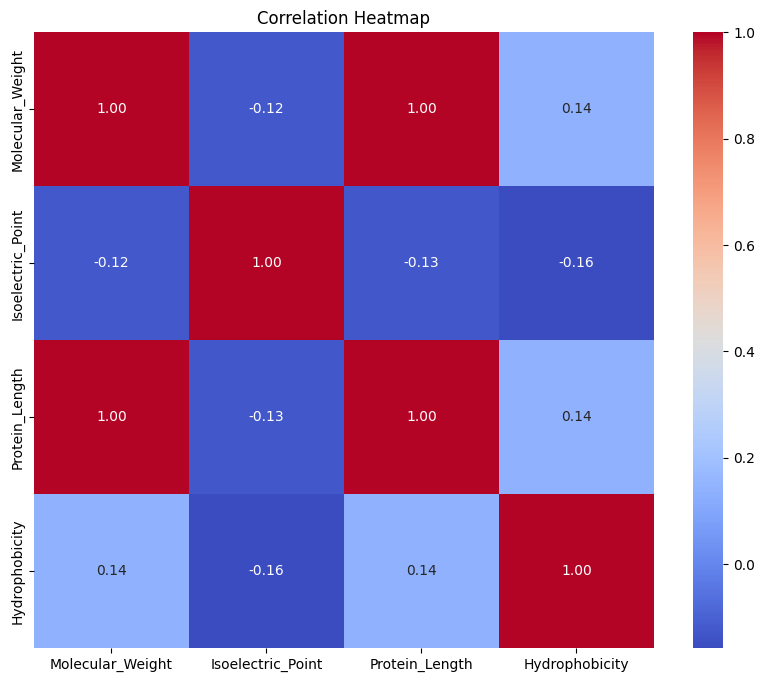

In [27]:
numerical_cols = bacteria.select_dtypes(include=[np.number])  # Sayısal sütunları seçiyoruz

# Korelasyon Matrisi oluşturuyoruz.
corr_matrix = numerical_cols.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

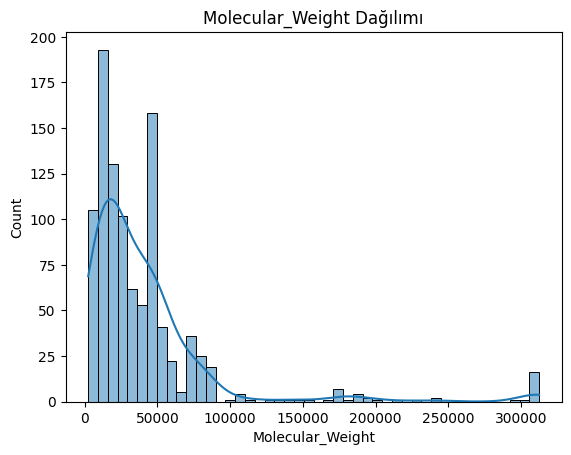

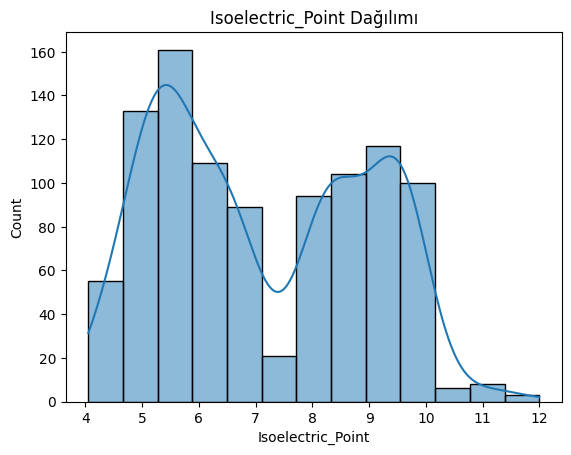

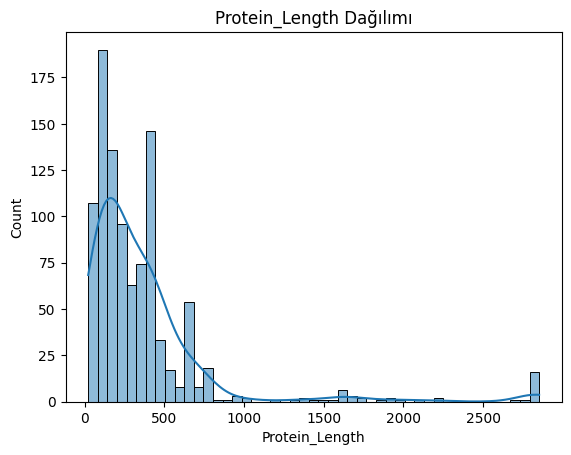

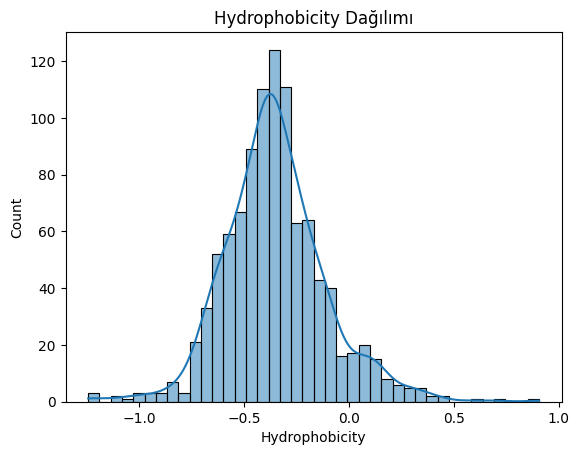

In [28]:
# Veri dağılımını inceliyoruz.
for col in numerical_cols:
    sns.histplot(bacteria[col], kde=True)
    plt.title(f'{col} Dağılımı')
    plt.show()

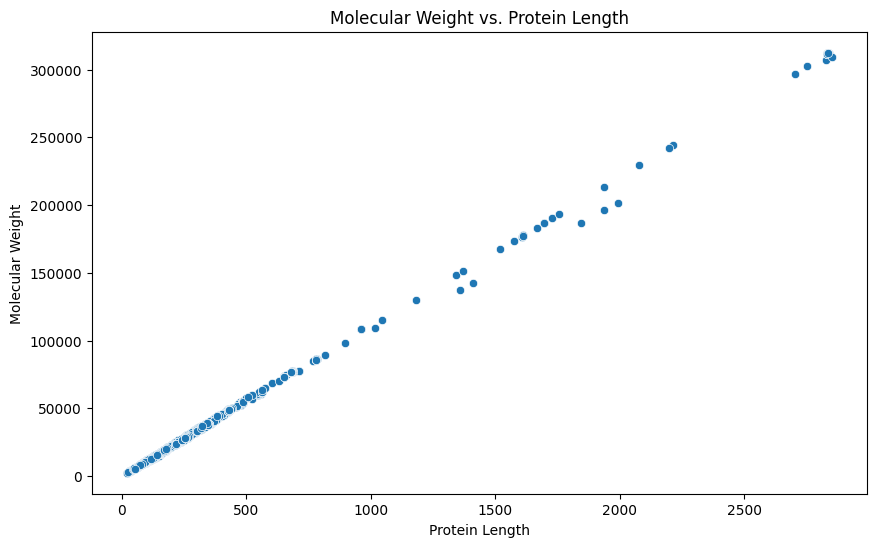

In [29]:
# Moleküler Ağırlığı ve Protein Uzunluğu karşılaştırmasıma ait dağılım grafiği
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Protein_Length', y='Molecular_Weight', data=bacteria)
plt.title('Molecular Weight vs. Protein Length')
plt.xlabel('Protein Length')
plt.ylabel('Molecular Weight')
plt.show()

4-MAKİNE ÖĞRENİMİ

In [30]:
from sklearn.ensemble import RandomForestRegressor
# Test ve Train kısımlarının ayrılması ve makine öğrenmesi uygulanması
X = numerical_cols.drop(columns=['Molecular_Weight'])
y = numerical_cols['Molecular_Weight']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse, r2

(3052987.694794333, 0.998565726340046)